In [1]:
import numpy as np
import xarray as xr
import gcsfs
from matplotlib import pyplot as plt
from xgcm import Grid
from xhistogram.xarray import histogram
%matplotlib inline
from matplotlib import colors as cols
import scipy.special as sp
from intake import open_catalog
import cmocean

In [2]:
# matplotlib.rcParams.update({'font.size': 22})
plt.rcParams.update({'font.size': 16})

In [3]:
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/channel.yaml")
ds01  = cat["channel_ridge_resolutions_01km"].to_dask()
ds05  = cat["channel_ridge_resolutions_05km"].to_dask()
ds20  = cat["channel_ridge_resolutions_20km"].to_dask()

In [4]:
grid20 = Grid(ds20, periodic='X')
grid05 = Grid(ds05, periodic='X')
grid01 = Grid(ds01, periodic='X') 

In [5]:
horispace01 = 1e3
horispace05 = 5e3
horispace20 = 20e3
time_index = 0
depth = -50
f =  -0.83e-4
daytime = 86400
alpha = 2e-4
gravity = 9.81
ybound = 2e5

In [6]:

depth = 0
vort01_0 = grid01.interp(grid01.interp((grid01.diff(ds01.V.sel(Z=depth,method='nearest'), 'X') - grid01.diff(ds01.U.sel(Z=depth,method='nearest'), 'Y', boundary='extend')),
                   'X'), 'Y', boundary='extend')/horispace01

strain01_0 = ((grid01.diff(ds01.U.sel(Z=depth,method='nearest'), 'X') - grid01.diff(ds01.V.sel(Z=depth,method='nearest'), 'Y', boundary='extend'))**2 + 
          (grid01.interp(grid01.interp(grid01.diff(ds01.V.sel(Z=depth,method='nearest'), 'X') + grid01.diff(ds01.U.sel(Z=depth,method='nearest'), 'Y', boundary='extend'),
                       'X'), 'Y', boundary='extend'))**2)**0.5/horispace01

<ipython-input-8-0d64601a3284>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(test.XC.values/1000,test.YC.values/1000,test, vmax=1,vmin=-1,cmap ='cmo.curl', rasterized=True)


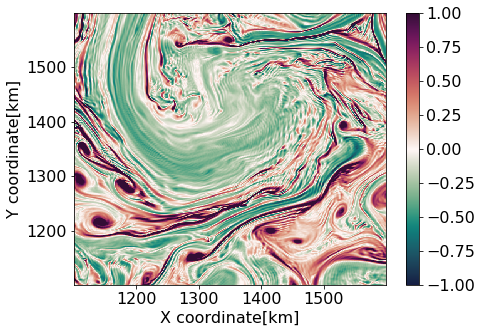

In [8]:
plt.figure(figsize=(7,5))
# plt.pcolormesh(vort05_0.XC.values/1000,vort05_0.YC.values/1000,(vort05_0/f).rename('').isel(time=10), vmax=1,cmap ='cmo.curl', rasterized=True)
test = (vort01_0/f).rename('').isel(time=10).sel(XC = slice(11e5,16e5), YC = slice(11e5,16e5))
# plt.title('surface vorticity$/|f_0|$')
plt.pcolormesh(test.XC.values/1000,test.YC.values/1000,test, vmax=1,vmin=-1,cmap ='cmo.curl', rasterized=True)
plt.xlabel('X coordinate[km]')
plt.ylabel('Y coordinate[km]')
plt.colorbar()

<ipython-input-9-4acf4c2070b8>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(test.XC.values/1000,test.YC.values/1000,test, vmax=1, vmin=0,cmap ='cmo.thermal', rasterized=True)


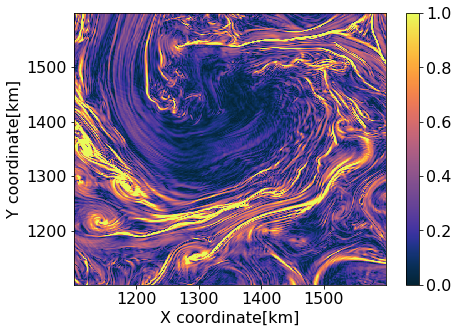

In [9]:
plt.figure(figsize=(7,5))
# plt.pcolormesh(vort05_0.XC.values/1000,vort05_0.YC.values/1000,(vort05_0/f).rename('').isel(time=10), vmax=1,cmap ='cmo.curl', rasterized=True)
test = (strain01_0/abs(f)).rename('').isel(time=10).sel(XC = slice(11e5,16e5), YC = slice(11e5,16e5))
# plt.title('surface vorticity$/|f_0|$')
plt.pcolormesh(test.XC.values/1000,test.YC.values/1000,test, vmax=1, vmin=0,cmap ='cmo.thermal', rasterized=True)
plt.xlabel('X coordinate[km]')
plt.ylabel('Y coordinate[km]')
plt.colorbar()

In [10]:

vort_01_sel = (vort01_0.isel(time=10).sel(XC = slice(11e5,16e5), YC = slice(11e5,16e5))/f).rename('vort1_0')
strain_01_sel = (abs(strain01_0.isel(time=10).sel(XC = slice(11e5,16e5), YC = slice(11e5,16e5))/f)).rename('strain1_0')


hab01_sel = histogram(vort_01_sel,strain_01_sel,dim = ['XC','YC'] , bins=[vortband01,strainband01])
hab01_sel.load()

<xarray.DataArray 'histogram_vort1_0_strain1_0' (vort1_0_bin: 239, strain1_0_bin: 239)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * vort1_0_bin    (vort1_0_bin) float64 -6.971 -6.912 -6.854 ... 6.912 6.971
  * strain1_0_bin  (strain1_0_bin) float64 0.01514 0.04443 ... 6.956 6.985

<ipython-input-12-f855af05d165>:6: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  test.plot(vmax=1e2,norm=cols.SymLogNorm(1e-4), cmap ='Reds')


Text(0, 0.5, '$\\sigma$/$|f_0|$')

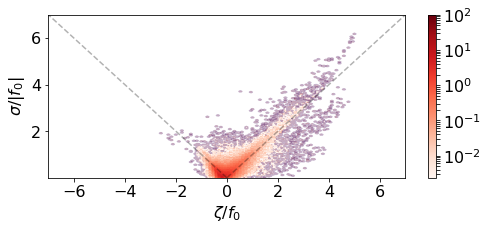

In [12]:
plt.figure(figsize=(8,3))

girbNums01sel = len(vort_01_sel.YC)*len(strain_01_sel.XC)
test = (1/(binbox01*girbNums01sel)*(hab01_sel.rename('')).T)
test = xr.where(test<1e-5,np.nan,test)
test.plot(vmax=1e2,norm=cols.SymLogNorm(1e-4), cmap ='Reds')
# plt.contour(np.linspace(-7, 7, 59), np.linspace(.5e-3, 7, 59), binbox01*(1**2)*hab01_00.mean(dim='time').T, levels=[0.5e1,1.5e2,1e4],colors ='k')
# plt.title('1km')
plt.contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((1**2)/(binbox01*girbNums01sel)*hab01_sel.T), levels=[1e-4],  alpha=.3)
plt.plot(np.linspace(0,-7,10),np.linspace(0,7,10),'k--',alpha=.3)
plt.plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
# plt.plot(np.linspace(0,7),np.sqrt(2)*np.linspace(0,7),'k:',alpha=.3)
plt.xlabel('$\zeta$/$f_0$')
plt.ylabel('$\sigma$/$|f_0|$')

In [7]:
hist01 = xr.open_dataarray('hist01')

vortband01 = np.linspace(-7, 7, 240)
strainband01 = np.linspace(.5e-3, 7, 240)

binbox01 =  (vortband01[1]-vortband01[0])*(strainband01[1]-strainband01[0])

In [13]:

hist01TMean = hist01.mean(dim='time')

mask_vortDom = xr.where(abs(hist01TMean.vort1_0_bin)>abs(hist01TMean.strain1_0_bin),1,0)

mask_ac = xr.where(hist01TMean.vort1_0_bin<0,1,0)

mask_c = xr.where(hist01TMean.vort1_0_bin>0,1,0)

mask_strDom = xr.where(abs(hist01TMean.vort1_0_bin)<abs(hist01TMean.strain1_0_bin),1,0)


In [20]:
val = ((1**2)/(binbox01*2000**2)*(hist01.rename('')).mean(dim='time').T)

val = xr.where(val*mask_strDom<1e-5,0,1)
# val = xr.where(val*mask_vortDom*mask_ac<1e-5,0,1)
# val = xr.where(val*mask_vortDom*mask_c<1e-5,0,1)



In [21]:
strainXY = xr.DataArray(val.strain1_0_bin.values,coords=[val.strain1_0_bin.values], dims=['strain1_0_bin'])
valStrain = strainXY*val
valStrain2 = xr.where(valStrain==0,np.nan,valStrain)

strainMin = valStrain2.min(dim='strain1_0_bin')
strainMax = valStrain2.max(dim='strain1_0_bin')


timeindex = 10
vortInt = ((vort01_0.isel(time=timeindex)/f -val.vort1_0_bin[0])/(val.vort1_0_bin[1]-val.vort1_0_bin[0])).astype(int) - 1
vortInt2 = xr.where(vortInt>=239,238,vortInt)
strainOrigin = strain01_0.isel(time=timeindex)/abs(f)


fullmask = xr.zeros_like(vort01_0.isel(time=timeindex))
for i in range(238):
    if(np.isnan(strainMin[i])):
        continue
    tempmask = xr.where(vortInt2==i,1,0)*xr.where(strainOrigin>=strainMin[i],1,0)*xr.where(strainOrigin<=strainMax[i],1,0)
    fullmask = fullmask + tempmask
    fullmask.load()

In [22]:
fullmaskV = fullmask
# fullmaskAC = fullmask
# fullmaskC = fullmask

In [23]:
whV = fullmaskV*vort01_0.isel(time=timeindex)
whAC = fullmaskAC*vort01_0.isel(time=timeindex)
whC = fullmaskC*vort01_0.isel(time=timeindex)

<ipython-input-24-20f574b90a77>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(test.XC.values/1000,test.YC.values/1000,test, vmax=1, vmin=-1,cmap ='cmo.curl', rasterized=True)


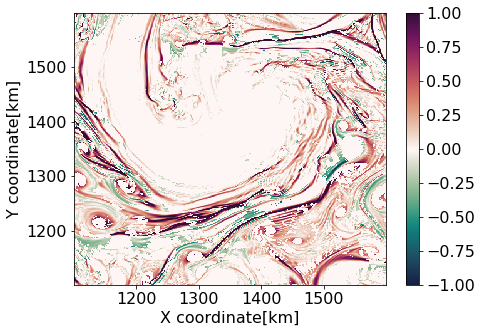

In [24]:
plt.figure(figsize=(7,5))
test = ((whV)/f).sel(XC = slice(11e5,16e5), YC = slice(11e5,16e5))
plt.pcolormesh(test.XC.values/1000,test.YC.values/1000,test, vmax=1, vmin=-1,cmap ='cmo.curl', rasterized=True)
# plt.title("surface vorticity$/|f_0|$, 'F'")
plt.xlabel('X coordinate[km]')
plt.ylabel('Y coordinate[km]')
plt.colorbar()

<ipython-input-25-08b7e3a05246>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(test.XC.values/1000,test.YC.values/1000,test, vmax=1, vmin=-1,cmap ='cmo.curl', rasterized=True)


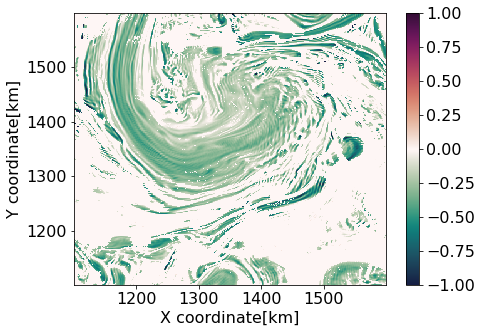

In [25]:
plt.figure(figsize=(7,5))
test = ((whAC)/f).sel(XC = slice(11e5,16e5), YC = slice(11e5,16e5))
plt.pcolormesh(test.XC.values/1000,test.YC.values/1000,test, vmax=1, vmin=-1,cmap ='cmo.curl', rasterized=True)
# plt.title("surface vorticity$/|f_0|$, 'F'")
plt.xlabel('X coordinate[km]')
plt.ylabel('Y coordinate[km]')
plt.colorbar()

<ipython-input-26-9f99ab7ff2b7>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(test.XC.values/1000,test.YC.values/1000,test, vmax=1, vmin=-1,cmap ='cmo.curl', rasterized=True)


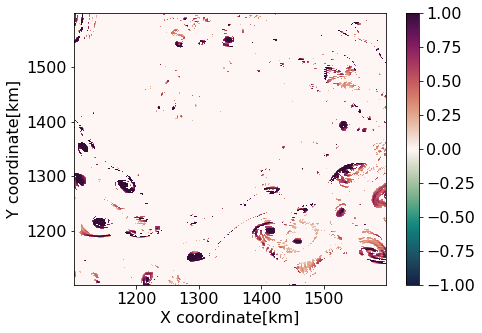

In [26]:
plt.figure(figsize=(7,5))
test = ((whC)/f).sel(XC = slice(11e5,16e5), YC = slice(11e5,16e5))
plt.pcolormesh(test.XC.values/1000,test.YC.values/1000,test, vmax=1, vmin=-1,cmap ='cmo.curl', rasterized=True)
# plt.title("surface vorticity$/|f_0|$, 'F'")
plt.xlabel('X coordinate[km]')
plt.ylabel('Y coordinate[km]')
plt.colorbar()